<a href="https://colab.research.google.com/github/shaileshk/ImageClassification/blob/master/ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Tensorflow Image Classification Model with Jewellery dataset in Google Colab**

**Prepare Colab Notebook**

First, to use GPU for fast training click "Runtime -> change runtime type" and set Hardware accelerator as GPU


To train model in Google Colab, prepare model by executing step by step instructions given below:



---


Step 1: **Initial setup**

Import libs and connect to Google drive for dataset. Authenticate with your drive account where the datasets is stored



---



In [1]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np
import pandas as pd 

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


TF version: 2.3.0
Hub version: 0.8.0
GPU is available
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive




---


Step 2: **TF2 Model selection**

Tensorflow model selection from tensorflow-hub development portal

---



In [2]:
module_selection = ("inception_v3", 299) #@param ["(\"mobilenet_v2_100_224\", 224)", "(\"inception_v3\", 299)"] {type:"raw", allow-input: true}
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32 #@param {type:"integer"}


Using https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4 with input size (299, 299)




---


Step 3: **Set up the dataset**

Link image directory to goolge drive from dataset

1.   Connect to goolge drive dataset
2.   Set data augmentation boolean value to True/ False.  This way we create variations of the images that can improve the ability of the fit model to generalize what it have learned to new images. 

> *Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset.*

3. Learn more about the dataset


---


In [4]:
data_dir = '/content/drive/My Drive/colab/jewellery/jewellery'


In [5]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 341 images belonging to 5 classes.
Found 1372 images belonging to 5 classes.




---


Learn more about data batches


---



In [6]:
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

Image batch shape:  (32, 299, 299, 3)
Label batch shape:  (32, 5)
['Bracelet' 'Earrings' 'Necklace' 'Rings' 'Wristwatch']




---


Step 4: **Defining the Model**

As a base model for transfer learning, use MobileNet v2 or Inception v3 model stored on Tensorflow Hub (selected in step 2)

---




In [7]:
do_fine_tuning = True #@param {type:"boolean"}

print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 21,778,597
Non-trainable params: 34,432
_________________________________________________________________




---


Step 5: **Training the model**


We can train our model and also modify epoches and test the accuracy.


---



In [8]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [9]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size 
hist = model.fit(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/5
42/42 [==============================] - ETA: 0s - loss: 1.0494 - accuracy: 0.7948

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


42/42 [==============================] - 455s 11s/step - loss: 1.0494 - accuracy: 0.7948 - val_loss: 1.1059 - val_accuracy: 0.8219
Epoch 2/5
42/42 [==============================] - 39s 927ms/step - loss: 0.7297 - accuracy: 0.9672 - val_loss: 0.8346 - val_accuracy: 0.9156
Epoch 3/5
42/42 [==============================] - 39s 938ms/step - loss: 0.6938 - accuracy: 0.9873 - val_loss: 0.8350 - val_accuracy: 0.9156
Epoch 4/5
42/42 [==============================] - 39s 927ms/step - loss: 0.6848 - accuracy: 0.9843 - val_loss: 0.7731 - val_accuracy: 0.9406
Epoch 5/5
42/42 [==============================] - 39s 930ms/step - loss: 0.6644 - accuracy: 0.9948 - val_loss: 0.8158 - val_accuracy: 0.9031




---


Step 6: **Visualize Model Training History**

Plot of accuracy and loss on the training and validation datasets over training epochs


---



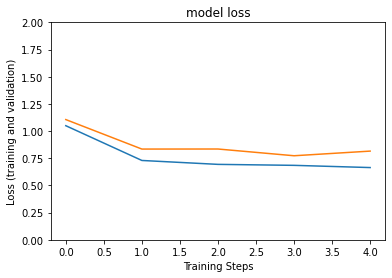

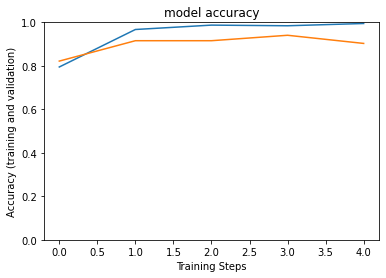

In [10]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.title('model loss')
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.title('model accuracy')
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])



---


Step7: **Exporting Model**

Export the model after training


---



In [11]:
JEWEL_SAVED_MODEL = "saved_models/jewellery"
tf.keras.models.save_model(model, JEWEL_SAVED_MODEL)
jewel_model = tf.keras.models.load_model(JEWEL_SAVED_MODEL,
custom_objects={'KerasLayer':hub.KerasLayer})

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: saved_models/jewellery/assets


INFO:tensorflow:Assets written to: saved_models/jewellery/assets


Get images and labels batch from validation dataset generator

In [12]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 299, 299, 3)




---


Step 8: **Testing the Model**

Calculate predictions for the entire batch


---



In [13]:
import pandas as pd
tf_model_predictions = jewel_model.predict(val_image_batch)
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels
print("Prediction results for the first elements")
tf_pred_dataframe.head()

Prediction results for the first elements


,Bracelet,Earrings,Necklace,Rings,Wristwatch
0,2.879739,-1.065719,-0.042289,-0.517819,-0.379160
1,2.810094,-0.899828,0.035233,0.044062,-1.019899
2,2.810094,-0.899828,0.035233,0.044062,-1.019899
3,1.427436,-0.938691,-0.986271,2.083357,-0.903407
4,1.427436,-0.938691,-0.986271,2.083357,-0.903407




---


Print images batch and labels predictions 


---



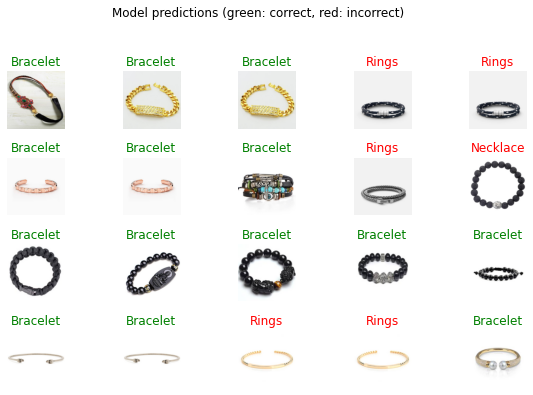

In [14]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")